# Identity function for MNIST; visualize weights

## Imports/data

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.cache()
# ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_test.batch(1000)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Create encoder/decoder $h_{dim} = 784$

In [ ]:
act='tanh'

enc = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28, 1)),  
  tf.keras.layers.Dense(28*28, activation=act)
])

dec = tf.keras.models.Sequential([
  # tf.keras.layers.Dense(28*28, input_shape=(28*28, ), activation=act),  
  tf.keras.layers.Reshape((28,28,1,),input_shape=(28*28, ))  
])


opt = tf.optimizers.Adam(1e-3)




for epoch in range(3):
  for batch in ds_train:
    with tf.GradientTape() as tape:
      recons = dec(enc(batch[0]))
      loss = tf.linalg.norm(recons-batch[0],axis=[1,2])
      loss = tf.reduce_mean(loss)
      print(loss)
      (g_enc, g_dec) = tape.gradient(loss,(enc.trainable_variables, dec.trainable_variables))
    opt.apply_gradients(zip(g_enc, enc.trainable_variables))
    opt.apply_gradients(zip(g_dec, dec.trainable_variables))

## Check "reconstructions" $h_{dim} = 784$

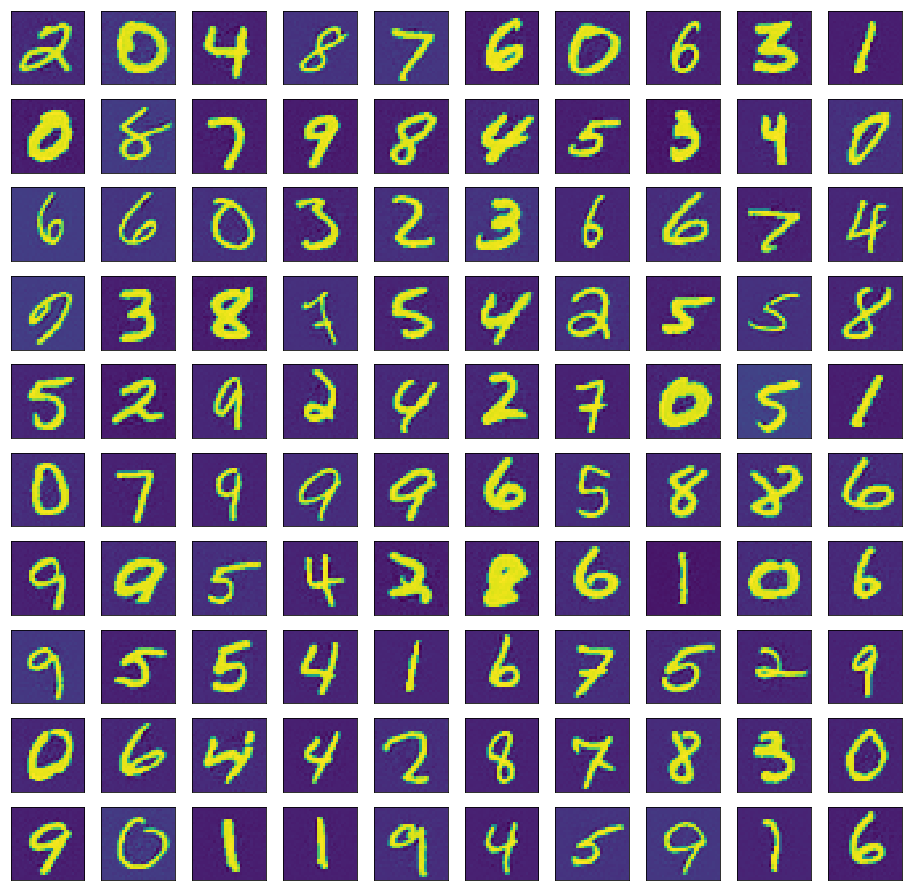

In [ ]:
import matplotlib.pyplot as plt


for test_images in ds_test.take(1):
  test_images = test_images[0][0:100,:,:]
  recons = dec(enc(test_images))
  images = recons.numpy().reshape((100,28,28))

  fig, axes = plt.subplots(10, 10, figsize=(16,16))
  for row in range(len(axes)):
    for col in range(len(axes[row])):
      axes[row][col].get_xaxis().set_visible(False)
      axes[row][col].get_yaxis().set_visible(False)
      axes[row][col].matshow(images[row*10+col])
      # axes[row][col].matshow(latents[row*10+col])

##Visualize weights for $h_{dim} = 784$

(784, 784)
(784,)


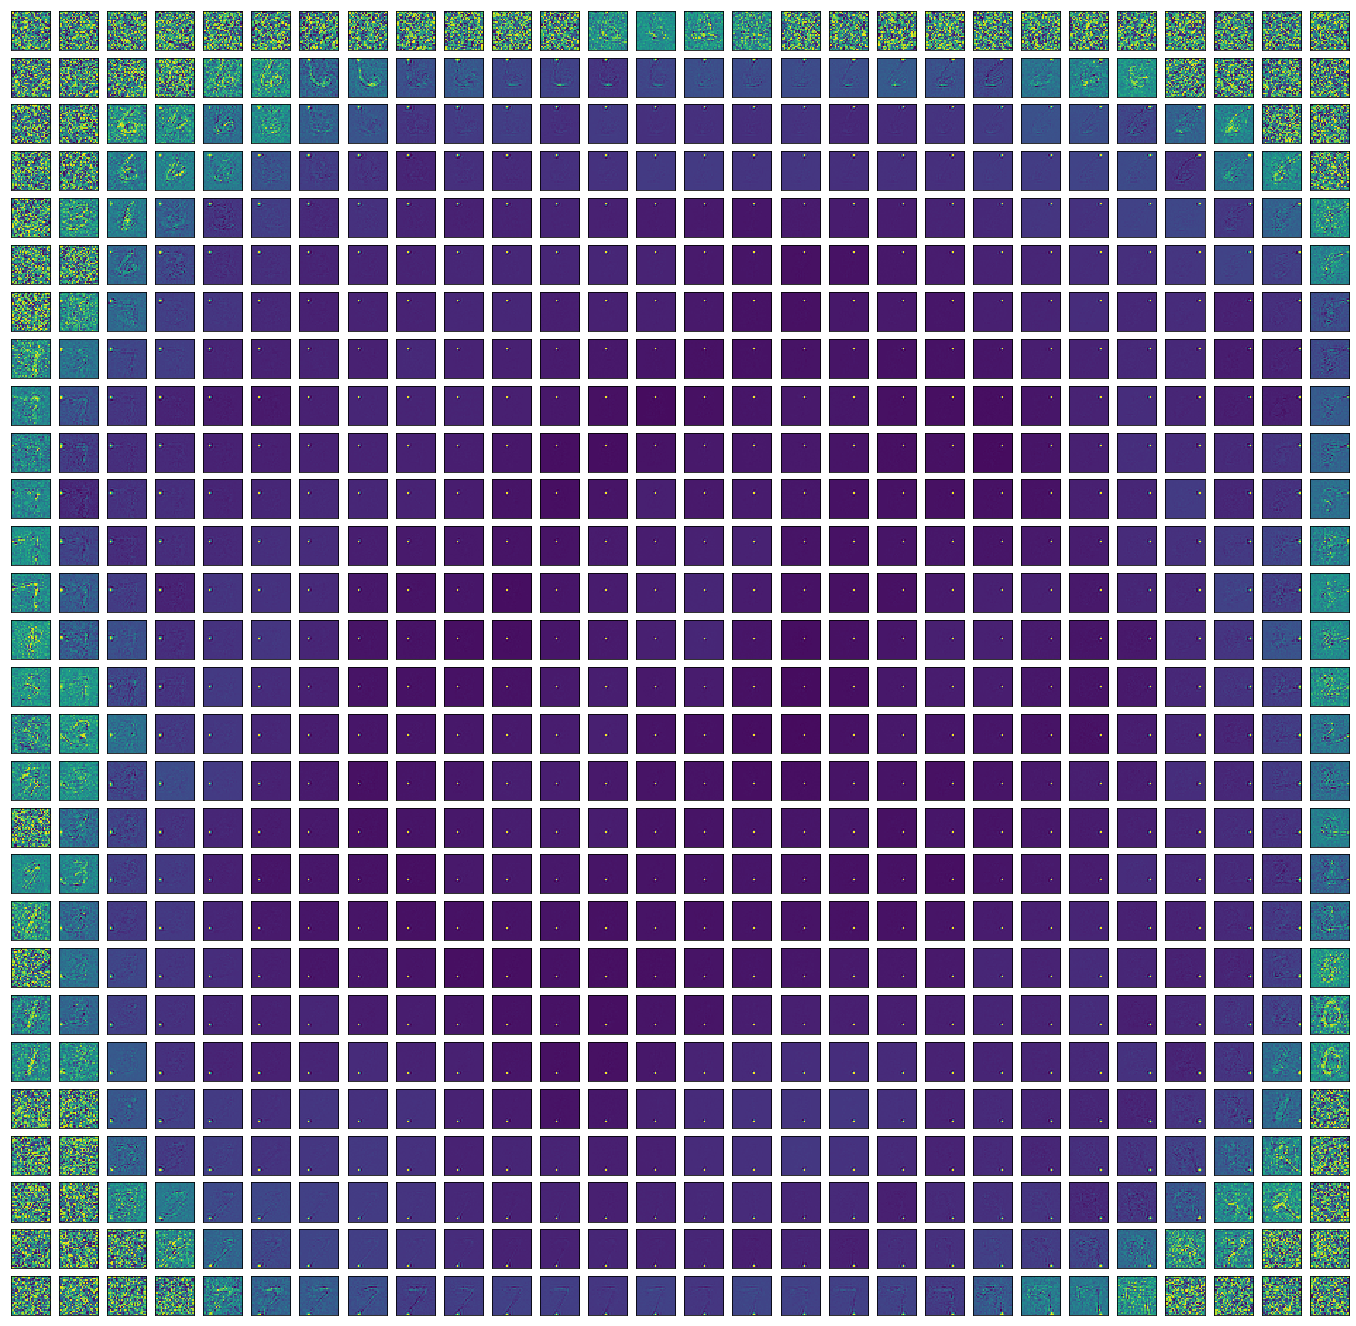

In [ ]:
# enc.summary()

for w in enc.get_weights():
  print(w.shape)

weights = enc.get_weights()[0]


grid = 28
fig, axes = plt.subplots(grid, grid, figsize=(24,24))
for row in range(len(axes)):
  for col in range(len(axes[row])):
    axes[row][col].get_xaxis().set_visible(False)
    axes[row][col].get_yaxis().set_visible(False)
    axes[row][col].matshow(weights[row*grid+col].reshape((28,28)))
    # axes[row][col].matshow(latents[row*10+col])  